# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。   
その解析結果をもとに、確実に利益の最小値がプラスになるスキームを構築する。

# 前回までのまとめ
cross pointの直後で注文し、EMA二本の差の極大・極小点のうち最も近い位置の次の点で約定をした場合、特定のポイントの組 (N1, N2) に対してプラスの利益が出ることが分かった。   
しかしながら、対象としたデータは次の観点で不完全であった。

+ 一つはticker data から作成したOHLC
+ 一つはCryptoCompareから取得したOHLCVで、bitflyerの実際のデータと異なっていた

今回は約定履歴から作製したOHLCVデータを用いて、同じ結果が得られるかどうか検討する。

## このノートで調査する内容
* N1, N2を変え、最も利益の出る組み合わせを探す。

## モジュールと関数の用意

In [2]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle
import sys
sys.path.append("./")
from utils import *

%matplotlib inline

## メイン関数

In [40]:
def main(df, N1, N2, N_dec=5):
    """main(df, N1, N2, N_dec=5) -> dict
    calculate some factors
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])

            # minimum index
            index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (mintab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = max(open_[tm+1], close_[tm+1])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            # maximum index
            index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = min(open_[tm+1], close_[tm+1])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == -1]):
        v = benefits[a_k[:, 1] == -1][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == 1]):
        v = benefits[a_k[:, 1] == 1][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

In [41]:
def main_peak(df, N1, N2, N_dec=5):
    """main_peak(df, N1, N2, N_dec=5) -> dict
    calculate some factors for peak-contract scheme
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])
            
            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = max(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = max(o_[tm], c_[tm])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = min(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = min(o_[tm], c_[tm])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]

    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == -1]):
        v = benefits[a_k[:, 1] == -1][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == 1]):
        v = benefits[a_k[:, 1] == 1][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [42]:
savename = "analysis_of_ohlc(201901010000-201901090000)-2"

In [43]:
filelist = [
    "../data/ohlcv/OHLCV_201901010000_to_201901070000.csv",
    "../data/ohlcv/OHLCV_201901070001_to_201901080000.csv",
    "../data/ohlcv/OHLCV_201901080001_to_201901090000.csv",
]

df = None
for fpath in filelist:
    if df is None:
        df = pd.read_csv(fpath, index_col=0)
    else:
        df = pd.concat((df, pd.read_csv(fpath, index_col=0)))
df.head()

,time,id_start,open,high,low,close,volume
0,1.546236e+09,694426164,419209,421060,419022,419732,350
1,1.546236e+09,694427312,419898,422592,418124,419352,1000
2,1.546236e+09,694430055,419352,419727,416443,416697,779
3,1.546236e+09,694433381,416443,417700,409500,413668,2184
4,1.546236e+09,694437582,410638,417000,410612,414100,1281


In [44]:
df.tail()

,time,id_start,open,high,low,close,volume
1435,1.546927e+09,713225777,440470,440507,440315,440445,54
1436,1.546927e+09,713227499,440451,440499,440219,440228,61
1437,1.546927e+09,713229183,440242,440324,440100,440144,167
1438,1.546927e+09,713231807,440144,440298,439238,439800,650
1439,1.546927e+09,713236204,439800,440252,439705,440156,296


In [45]:
len(df)

11521

## N1とN2を変動させて計算
N1とN2はCombinationで生成する。

In [46]:
import time

N_dec=5
N_max= 20

st = time.time()
comb_list = []
results_list = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    comb_list.append([x, y])
    results_list.append(main(df, x, y, N_dec))
#     break
print(time.time() - st)

210.1254026889801


In [47]:
benefits_list = []
for results in results_list:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list.append([dead_, golden_])

In [48]:
benefits_list

[[-193520, -199850],
 [-161379, -172828],
 [-138376, -141782],
 [-116393, -118329],
 [-100892, -110954],
 [-95281, -105648],
 [-91315, -100460],
 [-90103, -100002],
 [-78980, -91262],
 [-72767, -83490],
 [-68960, -74639],
 [-61097, -69726],
 [-56871, -65511],
 [-52457, -63910],
 [-48425, -60555],
 [-47131, -59658],
 [-45014, -55834],
 [-41896, -52622],
 [-41747, -55071],
 [-97891, -94320],
 [-89340, -82921],
 [-83826, -73821],
 [-67886, -71237],
 [-59871, -70032],
 [-50373, -61033],
 [-51195, -61635],
 [-38127, -56279],
 [-31007, -49778],
 [-37676, -47397],
 [-38542, -42042],
 [-38557, -38917],
 [-38156, -39898],
 [-34110, -40785],
 [-30142, -37006],
 [-31249, -37858],
 [-29555, -36926],
 [-28804, -35153],
 [-38200, -34297],
 [-47451, -46289],
 [-45512, -44525],
 [-37611, -40015],
 [-33243, -54687],
 [-31889, -46371],
 [-30821, -43255],
 [-23848, -40509],
 [-24472, -40136],
 [-27748, -36663],
 [-23704, -33072],
 [-23645, -32000],
 [-25131, -32545],
 [-20623, -32425],
 [-22318, -31628],

### ベストな場合

In [49]:
results_list_best = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    results_list_best.append(main_peak(df, x, y, N_dec))

In [50]:
benefits_list_best = []
for results in results_list_best:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list_best.append([dead_, golden_])

In [51]:
benefits_list_best

[[-111409, -128909],
 [-45054, -41485],
 [2913, 8005],
 [24180, 31907],
 [42893, 48076],
 [48894, 51029],
 [46718, 58551],
 [48781, 64174],
 [60508, 66812],
 [66402, 73658],
 [69622, 80341],
 [73058, 86399],
 [73517, 93464],
 [77084, 92360],
 [79481, 96497],
 [78751, 97361],
 [80960, 99763],
 [77792, 106702],
 [78114, 100957],
 [43807, 51442],
 [63084, 76178],
 [69981, 83956],
 [76930, 92810],
 [82540, 94545],
 [85466, 103798],
 [79612, 104127],
 [84751, 105454],
 [83386, 102768],
 [83097, 102769],
 [86408, 109689],
 [85970, 113334],
 [85484, 117876],
 [83864, 117654],
 [85399, 119052],
 [88844, 117269],
 [91210, 118402],
 [92280, 119122],
 [76641, 89518],
 [75111, 94702],
 [75494, 97667],
 [78396, 105893],
 [80592, 103513],
 [82452, 101513],
 [82553, 104755],
 [83701, 109050],
 [83947, 109400],
 [82973, 110997],
 [86690, 114951],
 [87555, 115013],
 [86884, 112822],
 [91257, 110462],
 [91657, 111405],
 [93344, 109155],
 [93360, 109271],
 [74685, 97586],
 [76307, 102085],
 [82430, 10085

### 抽出結果の整理

In [52]:
ary = np.zeros((len(comb_list), 6), dtype=int)
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    results_ = benefits_list[ii]
    results_best_ = benefits_list_best[ii]
    ary[ii] = np.array([comb_[0], comb_[1], results_[0], results_[1], results_best_[0], results_best_[1]])

In [53]:
benefits_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)
benefits_best_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)

for row in ary:
    benefits_2d[row[0], row[1], 0] = row[2] # dead
    benefits_2d[row[0], row[1], 1] = row[3] # golden
    benefits_best_2d[row[0], row[1], 0] = row[4] # dead
    benefits_best_2d[row[0], row[1], 1] = row[5] # golden

### それぞれの利益の最小値の期待値をイメージプロット

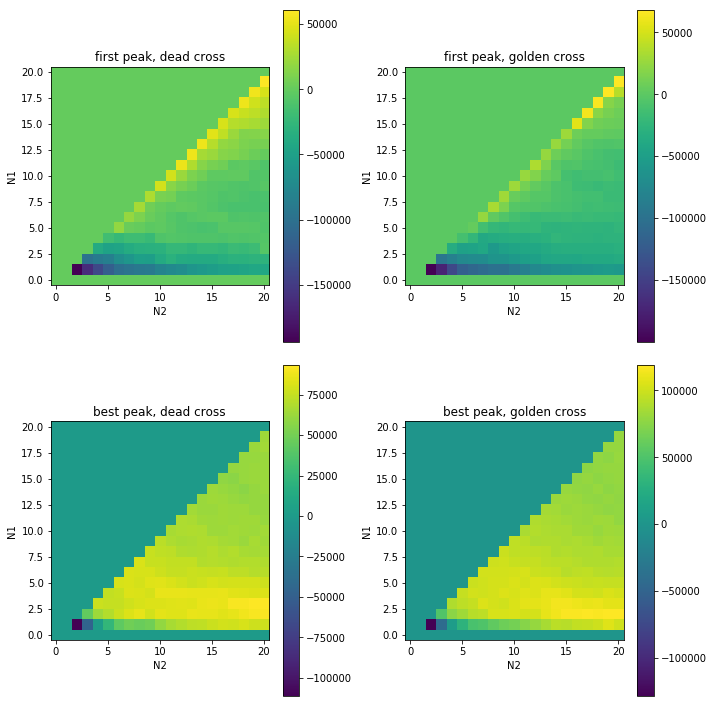

In [54]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, dead cross")
plt.colorbar()

plt.subplot(222)
plt.imshow(benefits_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, golden cross")
plt.colorbar()

plt.subplot(223)
plt.imshow(benefits_best_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, dead cross")
plt.colorbar()

plt.subplot(224)
plt.imshow(benefits_best_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, golden cross")
plt.colorbar()

plt.tight_layout()

### dead + golden のイメージプロット

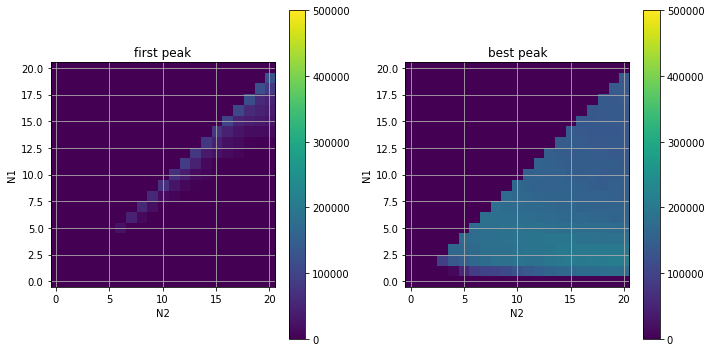

In [55]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(benefits_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("first peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.subplot(122)
plt.imshow(benefits_best_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("best peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.tight_layout()
plt.savefig("../images/{}.png".format(savename))

In [56]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())
print(np.where(benefits_best_2d.sum(axis=2)==benefits_best_2d.sum(axis=2).max()), benefits_best_2d.sum(axis=2).max())

(array([19], dtype=int64), array([20], dtype=int64)) 128212
(array([2], dtype=int64), array([20], dtype=int64)) 211402


In [57]:
benefits_2d.sum(axis=2)[17, 18]

119445

### 結果の保存

In [58]:
res = dict(
    results_list=results_list, results_list_best=results_list_best,
    N_max=N_max, comb_list=comb_list, benefits_list=benefits_list,
    benefits_list_best=benefits_list_best, benefits_2d=benefits_2d,
    benefits_best_2d=benefits_best_2d, ary=ary
)

with open("../data/{}.pickle".format(savename), "wb") as ff:
    pickle.dump(res, ff)

### 平均値のプロット

In [79]:
target = [17, 18]
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    if comb_[0] == target[0] and comb_[1] == target[1]:
        results = results_list[ii]
        break
ema1 = results["ema1"]
ema2 = results["ema2"]
ema_diff = ema1 - ema2
cross_points = results["cross_points"]
benefits = results["benefits"]
a_k = results["a_k"]

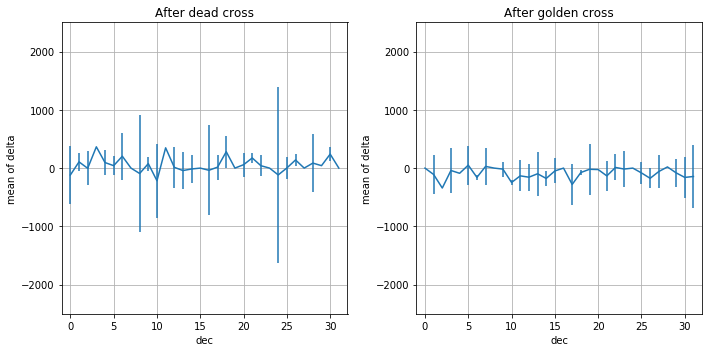

In [74]:
stat_dead = results["stat_dead"]
stat_golden = results["stat_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

### 箱ひげ図

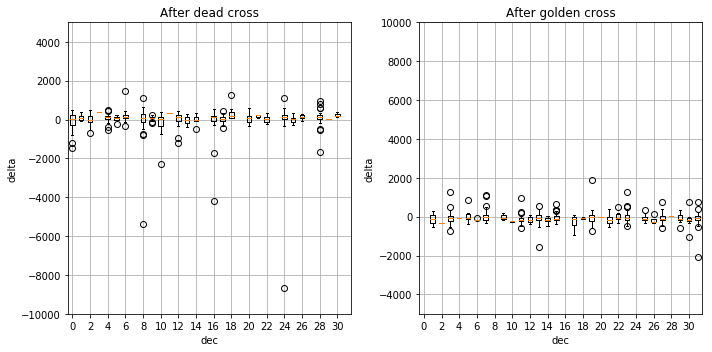

In [75]:
list_ext_dead = results["list_ext_dead"]
list_ext_golden = results["list_ext_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## OHLC等のプロット

In [76]:
for a, b in zip(a_k, benefits):
    print(a, b)

[ 1 -1] -1447
[20  1] -125
[41 -1] -137
[58  1] 340
[63 -1] 24
[87  1] -292
[88 -1] 80
[95  1] -176
[101  -1] 302
[121   1] -140
[128  -1] 1086
[149   1] -172
[177  -1] 216
[200   1] -188
[228  -1] -109
[248   1] -11
[256  -1] -291
[273   1] -297
[279  -1] -8665
[328   1] 11
[351  -1] 343
[357   1] -203
[358  -1] 326
[360   1] -44
[371  -1] 36
[378   1] 50
[385  -1] 396
[415   1] -246
[421  -1] 346
[437   1] 111
[452  -1] 181
[453   1] 1279
[506  -1] 166
[535   1] -41
[547  -1] 124
[553   1] -145
[556  -1] -97
[567   1] 476
[598  -1] 87
[668   1] -86
[672  -1] 94
[673   1] -168
[674  -1] 96
[677   1] -75
[686  -1] -218
[700   1] -183
[705  -1] -172
[717   1] 110
[754  -1] 114
[773   1] -168
[804  -1] 133
[829   1] -131
[832  -1] 40
[844   1] 319
[869  -1] 271
[875   1] -41
[878  -1] -94
[888   1] -185
[918  -1] -112
[929   1] 30
[937  -1] 179
[949   1] 78
[994  -1] 62
[1004    1] 89
[1027   -1] 158
[1036    1] 96
[1058   -1] 238
[1061    1] -114
[1067   -1] 468
[1069    1] -231
[1072  

[8577   -1] 160
[8602    1] -43
[8615   -1] 44
[8624    1] -38
[8658   -1] 96
[8667    1] -11
[8674   -1] -176
[8697    1] -115
[8710   -1] 165
[8719    1] 70
[8746   -1] 115
[8748    1] 205
[8828   -1] -38
[8838    1] -92
[8847   -1] 32
[8867    1] -182
[8878   -1] 242
[8883    1] -281
[8888   -1] 342
[8896    1] -174
[8900   -1] 263
[8902    1] 282
[8925   -1] 293
[8940    1] 157
[8953   -1] 1
[9015    1] -98
[9023   -1] -1190
[9040    1] 258
[9052   -1] 132
[9063    1] -210
[9095   -1] 230
[9125    1] 771
[9152   -1] -330
[9167    1] -282
[9173   -1] 133
[9181    1] 465
[9211   -1] 338
[9218    1] -149
[9221   -1] 25
[9286    1] -262
[9287   -1] 278
[9288    1] -15
[9297   -1] 195
[9331    1] -219
[9335   -1] 120
[9338    1] -70
[9339   -1] -281
[9353    1] -120
[9397   -1] 182
[9409    1] 77
[9422   -1] 124
[9423    1] -76
[9436   -1] -223
[9458    1] -118
[9462   -1] 6
[9498    1] -56
[9522   -1] 143
[9525    1] -105
[9542   -1] -96
[9563    1] -90
[9587   -1] -55
[9604    1] -155

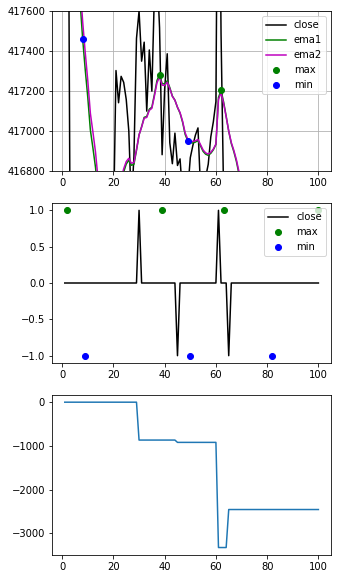

In [86]:
maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
close_ = df["close"].values
start = 0
end = 100 #len(ema1)

plt.figure(figsize=(5, 10))
plt.subplot(311)
plt.plot(np.arange(start+1, end+1), close_[start:end], "k", label="close")
plt.plot(np.arange(start+1, end+1), ema1[start:end], "g", label="ema1")
plt.plot(np.arange(start+1, end+1), ema2[start:end], "m", label="ema2")
plt.ylim(416800, 417600)
# index = (maxtab0[:, 0]>=start)&(maxtab0[:, 0]<end)
# plt.plot(maxtab0[index, 0], maxtab0[index, 1], "bo")
# index = (mintab0[:, 0]>=start)&(mintab0[:, 0]<end)
# plt.plot(mintab0[index, 0], mintab0[index, 1], "ro")

index = (maxtab_ema_diff[:, 0]>=start)&(maxtab_ema_diff[:, 0]<end)
plt.plot(1 + maxtab_ema_diff[index, 0], ema1[maxtab_ema_diff[index, 0].astype(int)], "go", label="max")
index = (mintab_ema_diff[:, 0]>=start)&(mintab_ema_diff[:, 0]<end)
plt.plot(1 + mintab_ema_diff[index, 0], ema1[mintab_ema_diff[index, 0].astype(int)], "bo", label="min")
plt.legend()
plt.grid(True)

plt.subplot(312)
plt.plot(np.arange(start+1, end+1), cross_points[start:end], "k", label="close")
index = (maxtab_ema_diff[:, 0]>=start)&(maxtab_ema_diff[:, 0]<end)
plt.plot(1 + maxtab_ema_diff[index, 0] + 1, np.ones(len(maxtab_ema_diff[index, 0])), "go", label="max")
index = (mintab_ema_diff[:, 0]>=start)&(mintab_ema_diff[:, 0]<end)
plt.plot(1 + mintab_ema_diff[index, 0] + 1, -np.ones(len(mintab_ema_diff[index, 0])), "bo", label="min")
plt.legend()

benefits_history = []
count = 0
for ii in range(len(ema1)):
    if ii == 0:
        benefits_history.append(0)
    elif count < len(a_k) and ii == a_k[count, 0]:
        benefits_history.append(benefits_history[-1] + benefits[count]*a_k[count, 1])
        count += 1
    else:
        benefits_history.append(benefits_history[-1])

plt.subplot(313)
plt.plot(np.arange(start+1, end+1), benefits_history[start:end], label="benefits")

In [84]:
a = max([4.5, 3.4])
a

4.5